参考

+ https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub
+ https://www.tensorflow.org/lite/convert/python_api
+ https://github.com/nex3z/tflite-mnist-android
+ https://proandroiddev.com/classifying-doodles-on-android-with-tensorflow-lite-be0afcf94450

本プログラムの [Google Colab](https://colab.research.google.com/drive/179JlRFf0xT82QlsaWMLRHc9Z1J4zINjK#scrollTo=aCdfHa-s5FFk&uniqifier=3) へ

In [0]:
!mkdir DATA
!mkdir DATA/carrot DATA/poteto DATA/broccoli

UPLOAD IMAGE DATA

# 画像データファイルのセット

In [0]:
import os
from glob import glob                                                           
import cv2 
pngs = glob('./**/*.png', recursive=True)

for j in pngs:
    print(j)
    img = cv2.imread(j)
    print(img)
    cv2.imwrite(j[:-3] + 'jpg', img)



In [0]:
gifs = glob('./**/*.gif', recursive=True)

for j in gifs:
    img = cv2.imread(j)
    cv2.imwrite(j[:-3] + 'jpg', img)

In [0]:
jpegs = glob('./**/*.jpeg', recursive=True)

for j in jpegs:
    img = cv2.imread(j)
    cv2.imwrite(j[:-4] + 'jpg', img)

In [0]:
!find -type f ! -regex ".*\.\(jpg\)" -delete

In [6]:
!find DATA/broccoli -type f | wc -l
!find DATA/carrot -type f | wc -l
!find DATA/poteto -type f | wc -l

131
151
84


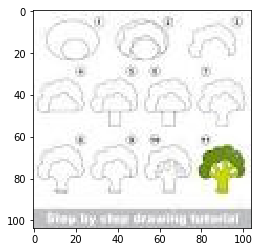

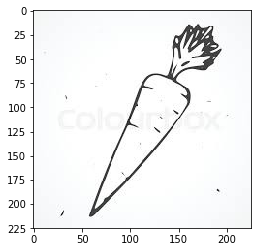

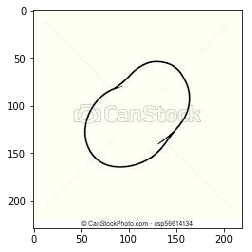

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

bro = Image.open("DATA/broccoli/image1.jpg")
ca = Image.open("DATA/carrot/image1.jpg")
po = Image.open("DATA/poteto/image.jpg")
bro = np.asarray(bro)
ca = np.array(ca)
po = np.array(po)
plt.imshow(bro)
plt.show()
plt.imshow(ca)
plt.show()
plt.imshow(po)
plt.show()

# TensorFlow

In [8]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TensorFlow 2.x selected.
TF version: 2.0.0-rc2
Hub version: 0.6.0
GPU is available


In [9]:
!mkdir /root/.keras/datasets/
!ls /root/.keras
!cp -r DATA /root/.keras/datasets/
#!ls /root/.keras/datasets/DATA/0

data_root = '/root/.keras/datasets/DATA'

datasets  keras.json


In [10]:
data_root

'/root/.keras/datasets/DATA'

## 画像データの分類

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [0]:
IMAGE_SHAPE = (224, 224)
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [13]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 366 images belonging to 3 classes.


In [14]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 3)


In [15]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

## レイヤー追加

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [18]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor_layer.trainable = False

In [20]:
# レイヤーの追加
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
predictions = model(image_batch)

In [22]:
predictions.shape

TensorShape([32, 3])

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

## 機械学習開始

In [25]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback])

Train for 12.0 steps
Epoch 1/10
12/12 [==============================] - 8s 707ms/step - loss: 0.7346 - acc: 0.8750
Epoch 2/10
12/12 [==============================] - 4s 341ms/step - loss: 0.2907 - acc: 0.9375
Epoch 3/10
12/12 [==============================] - 4s 337ms/step - loss: 0.1610 - acc: 1.0000
Epoch 4/10
12/12 [==============================] - 4s 345ms/step - loss: 0.1115 - acc: 1.0000
Epoch 5/10
12/12 [==============================] - 4s 338ms/step - loss: 0.0858 - acc: 1.0000
Epoch 6/10
12/12 [==============================] - 4s 337ms/step - loss: 0.0682 - acc: 1.0000
Epoch 7/10
12/12 [==============================] - 4s 338ms/step - loss: 0.0562 - acc: 0.9688
Epoch 8/10
12/12 [==============================] - 4s 339ms/step - loss: 0.0493 - acc: 1.0000
Epoch 9/10
12/12 [==============================] - 4s 337ms/step - loss: 0.0414 - acc: 1.0000
Epoch 10/10
12/12 [==============================] - 4s 340ms/step - loss: 0.0360 - acc: 1.0000


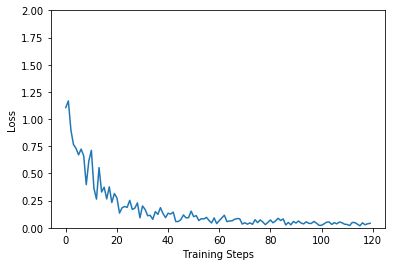

In [26]:
import matplotlib.pylab as plt
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

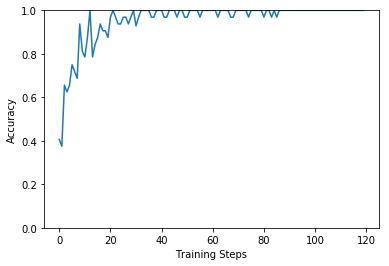

In [27]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [28]:
print("IN: " + str(model.input_shape))
print("OUT: " + str(model.output_shape))

IN: (None, 224, 224, 3)
OUT: (None, 3)


## 学習後の確認

In [29]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Broccoli', 'Carrot', 'Poteto'], dtype='<U8')

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [0]:
label_id = np.argmax(label_batch, axis=-1)

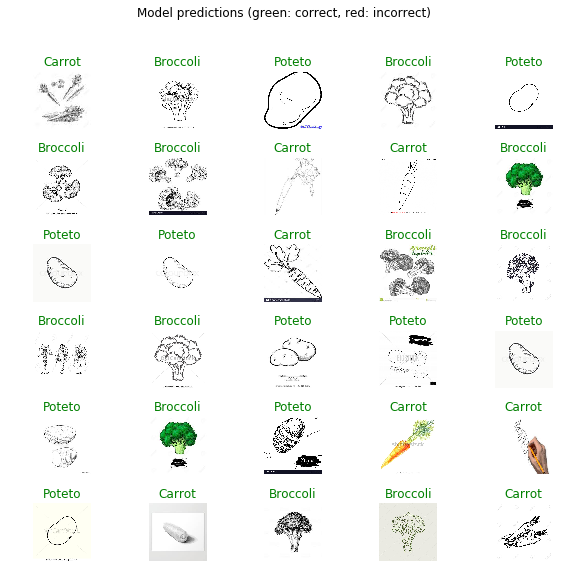

In [32]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## モデルの出力（.pb）

In [33]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

Instructions for updating:
Please use `model.save(..., save_format="tf")` or `tf.keras.models.save_model(..., save_format="tf")`.


Instructions for updating:
Please use `model.save(..., save_format="tf")` or `tf.keras.models.save_model(..., save_format="tf")`.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /tmp/saved_models/1570295175/saved_model.pb


INFO:tensorflow:SavedModel written to: /tmp/saved_models/1570295175/saved_model.pb


'/tmp/saved_models/1570295175'

## 作成したモデルのチェック

In [34]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

Instructions for updating:
The experimental save and load functions have been  deprecated. Please switch to `tf.keras.models.load_model`.


Instructions for updating:
The experimental save and load functions have been  deprecated. Please switch to `tf.keras.models.load_model`.


In [0]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [36]:
abs(reloaded_result_batch - result_batch).max()

0.0

## モデルを .pb から .tflite に変換

In [38]:
!ls /tmp/saved_models/1570295175

assets	saved_model.pb	variables


In [39]:
saved_model_path = '/tmp/saved_models/1570295175/'
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /tmp/saved_models/1570295175/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1570295175/assets


In [41]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()
open('vege-sketch.tflite', 'wb').write(tflite_model)

8890496

In [42]:
!ls

DATA  sample_data  vege-sketch.tflite


#### 作成した 〇〇.tflite を Android Studio にセット